# k-means classification for time series


Description:

In [1]:
# No normalzation for the classification !!!

## Import libraries

In [2]:
import numpy as np
import pandas as pd

# Images and plots
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
import matplotlib.image as mpimg
from osgeo import gdal
from google.colab import files # For download images

# Machine learning and statistics
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sms

# Texture
import skimage.filters.rank as rank
from skimage.filters.rank import maximum, mean, minimum
from numpy import arange
from skimage.feature import local_binary_pattern  # just to remember that there is this too

# To show statistical differences
import random
import statistics as stat

## Apply functions

In [3]:
# Gets an image with several layers as an array with
# three dimensions and returns the layers in a dictionary

def Image_As_Array_To_Image_As_Dictionary(_image_as_array):
  im = {'blue':1,  'green':1, 'red':1,
         'NIR':1, 'SWIR_1':1, 'SWIR_2':1}

  for i, band in enumerate(im):
    im[band] = np.array(_image_as_array[i, :, :])

  return im

In [4]:
# NOTE: this function may need adjustment

# Gets a year which is also the name of the image (+ .tif) and
# tries to read and return the image.
# Also trying to read year with (1) or (2)

def Read_Images(_year):
  # try to read the image
  try:
    image_file = gdal.Open(str(_year) + '.tif')
    multi_layer_image = image_file.ReadAsArray()
    im = Image_As_Array_To_Image_As_Dictionary(multi_layer_image)


    return True, im

  # if not exist
  except:

    # try to read the image withe (1)
    try:
      image_file = gdal.Open(str(_year) + '(1).tif')
      multi_layer_image = image_file.ReadAsArray()
      im = Image_As_Array_To_Image_As_Dictionary(multi_layer_image)

      return True, im

    # if not exist
    except:

      # try to read the image withe (2)
      try:
        image_file = gdal.Open(str(_year) + '(2).tif')
        multi_layer_image = image_file.ReadAsArray()
        im = Image_As_Array_To_Image_As_Dictionary(multi_layer_image)

        return True, im

      # if not exist
      except:

        return False, False

In [5]:
# Crops an image by row and column numbers

def Crop_Image(_image,  _first_row, _last_row, _first_column, _last_column):
  for band in _image:
    _image[band] =_image[band][_first_row : _last_row, _first_column: _last_column]

  return _image

In [6]:
# Receives an image after classification and a row and column number,
# if the pixel at this point is equal to zero, the function turns the zeros
# into ones and vice versa.
# By default the function takes the middle pixel

def Inverse_The_Classification_If_The_Pixel_Zero(_classify_image, _row = -1, _column = -1):
  if _row and _column < 0:
    num_of_row, num_of_column = _classify_image.shape
    _row = int( num_of_row / 2 )
    _column = int( num_of_column / 2 )

  if _classify_image[_row, _column] == 0:
    return ( _classify_image * (-1) + 1 )

  else:
    return _classify_image

In [7]:
def How_Many_Pixels_Are_Specific_Value(_image, _val = 1):
  pixels = 0
  rows, columns = _image.shape

  for row in range(rows):
    for colum in range(columns):
      if _image[row, colum] == _val:
         pixels = pixels + 1

  return pixels

In [8]:
def NDVI(_image):
  return ( _image['NIR'] - _image['red'] ) / ( _image['NIR'] + _image['red'] + 0.0000000001)

In [9]:
def Show_Image_Layers(_image):
  for layer in _image:
    plt.figure()
    plt.imshow(_image[layer], 'gray')

## Sand Classification

In [ ]:
# NOTE!!! pay attention to the comments in the code

not_classified = []
classified_images = []
years_list = []

first_year = 1986
last_year = 2022

for year in range(first_year, last_year + 1):
  year_exists, im = Read_Images(year)


  if year_exists == True:

    # NOTE!!! this line is image depending
    #im = Crop_Image(im, 0, 120, 10, 105)   # for west to duck
    #im = Crop_Image(im, 10, 100, 20, 105)   # for duck

    not_classified.append(im)

    # Filters - creating texture
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size))
    max_filter = []
    mean_filter = []

    for my_image in im:
      max_filter.append(maximum(im[my_image], kernel))
      mean_filter.append(mean(im[my_image], kernel))


    # Stack all layers in one array
    bands_amount = 6
    filters_amount = 2

    layers_amount = bands_amount *  filters_amount + bands_amount
    rows_amount, colums_amount = im['blue'].shape

    stack_img = np.zeros((rows_amount, colums_amount, layers_amount))

    for i, band in enumerate(im):
    # NOTE!!! all filters shold be in this loop
      stack_img[:, :, i] = im[band]
      stack_img[:, :, i + bands_amount] = mean_filter[i]
      stack_img[:, :, i + bands_amount * 2] = max_filter[i]


    # Flating tha layers array
    flat_img = stack_img.reshape((-1, layers_amount))

    # Clustering
    k = 2
    kmeans = KMeans(n_clusters=k).fit(flat_img)
    clusters = kmeans.predict(flat_img)

    # Reshape back
    clusters_img = clusters.reshape(im['blue'].shape)

    # Saves the classify image and year
    classified_images.append(clusters_img)
    years_list.append(year)

## Analysis and graphs

### Preparation

In [15]:
# Inverse the classification if need

for idx, image in enumerate(classified_images):
  classified_images[idx] = Inverse_The_Classification_If_The_Pixel_Zero(image)

In [16]:
# Calculate how much area is bare sand

bare_sand_pixels = []

for image in classified_images:
  bare_sand_pixels.append(How_Many_Pixels_Are_Specific_Value(image, 1))

In [ ]:
# The fourth year (1989) for this area had a bad classification so it was dropped

# NOTE!!! this line is image depending
#image_to_dalite = 3     # for west to duck
image_to_dalite = 2   # for duck

del not_classified[image_to_dalite]
del classified_images[image_to_dalite]
del bare_sand_pixels[image_to_dalite]
del years_list[image_to_dalite]

In [ ]:
# Print the classify images

for image in classified_images:
  plt.figure()
  plt.imshow(image, 'gray')

### Graphs

Text(0, 0.5, 'Number of pixels')

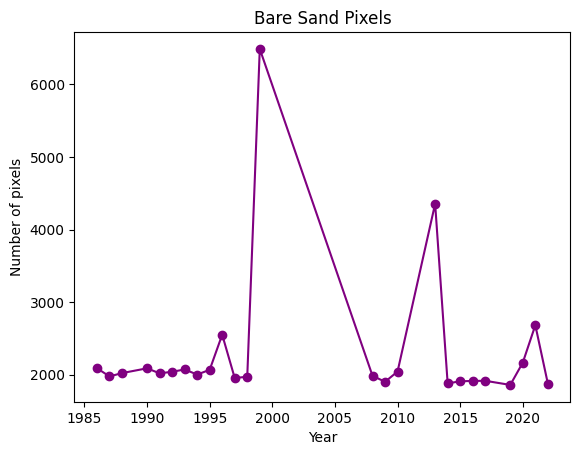

In [18]:
# Plot bear sand pixels vs. year

plt.plot(years_list, bare_sand_pixels, marker = 'o', color = 'purple')
plt.title('Bare Sand Pixels')
plt.xlabel('Year')
plt.ylabel('Number of pixels')

Text(0, 0.5, 'Percentage from 1986')

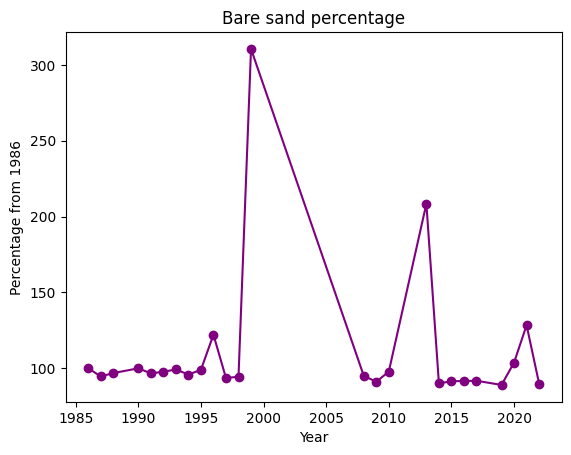

In [20]:
# Bare sand area in percentage from first year (1986)

bare_sand_percentage = []

for number_of_pixels in bare_sand_pixels:
  bare_sand_percentage.append( number_of_pixels /  bare_sand_pixels[0] * 100)

plt.plot(years_list, bare_sand_percentage, marker = 'o', color = 'purple')
plt.title('Bare sand percentage')
plt.xlabel('Year')
plt.ylabel('Percentage from 1986')

In [ ]:
data = {'year': years_list,
        'percentage': bare_sand_percentage,}

a =  pd.DataFrame(data)

a.to_csv('bar.csv')
files.download('bar.csv')

In [22]:
# Linear regression for percentage of bare sand vs. year

years_array = np.array(years_list).reshape(-1, 1)
bare_sand_percentage_array = np.array(bare_sand_percentage).reshape(-1, 1)

linear_regressor = LinearRegression().fit(years_array, bare_sand_percentage_array)
y_axis_for_fit_line = linear_regressor.predict(years_array)

r_square = linear_regressor.score(years_array, bare_sand_percentage_array)

In [ ]:
# Scatter plot with linear regression

plt.figure()
ax = plt.axes()
ax.scatter(years_list, bare_sand_percentage, color = 'purple')
ax.plot(years_list, y_axis_for_fit_line.flatten().tolist(), '--')

ax.set_title('Bare Sand Percentage')
ax.set_ylabel('Percentage from 1986')
ax.set_xlabel('Year')

In [24]:
# Print linear regression summary

years_array_with_constant = sms.add_constant(years_array)
est = sms.OLS(bare_sand_percentage_array, years_array_with_constant)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                 0.0007115
Date:                Wed, 12 Jul 2023   Prob (F-statistic):              0.979
Time:                        17:56:43   Log-Likelihood:                -131.75
No. Observations:                  25   AIC:                             267.5
Df Residuals:                      23   BIC:                             269.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        154.1571   1629.726      0.095      0.9

### NDVI exam

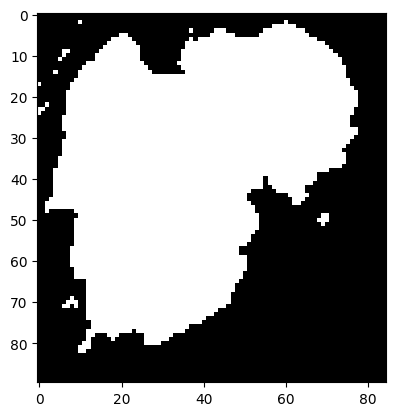

In [ ]:
# Shows the oldest image

plt.imshow(classified_images[0], 'gray')

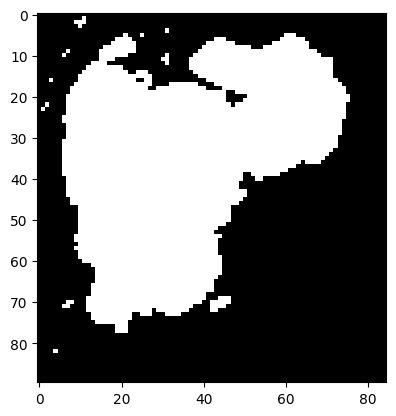

In [ ]:
# Showing the newest image

plt.imshow(classified_images[-1], 'gray')

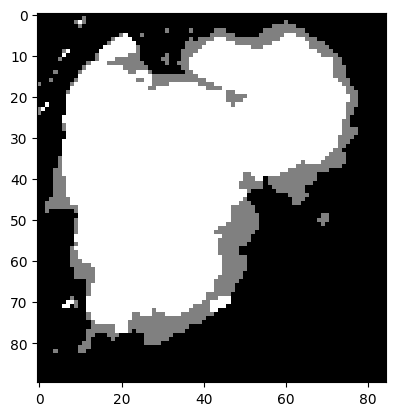

In [ ]:
# Shows the differences between the newest and the oldest

differences = classified_images[-1] + classified_images[0]
plt.imshow(differences, 'gray')

In [ ]:
my_diff_image = not_classified[-1]

my_diff_image['differences'] = differences
my_diff_image['NDVI'] = NDVI(my_diff_image)

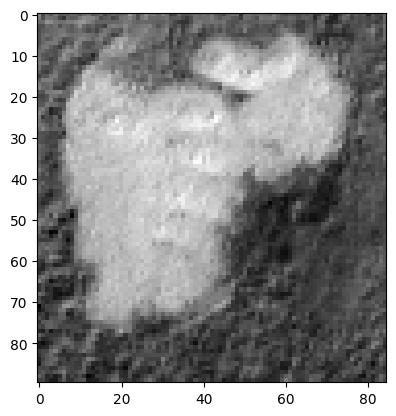

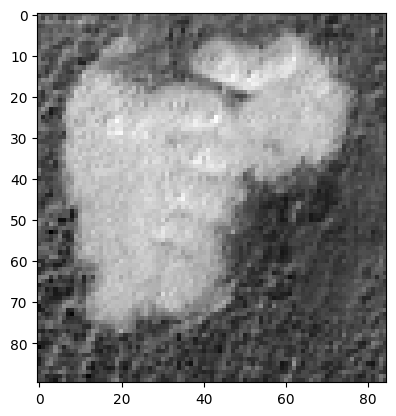

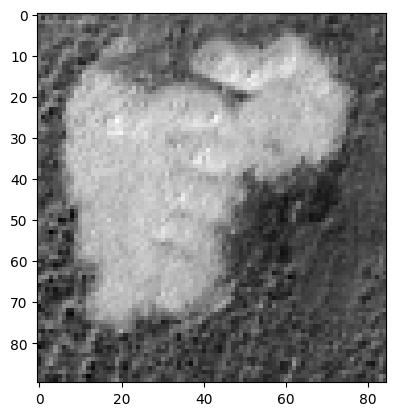

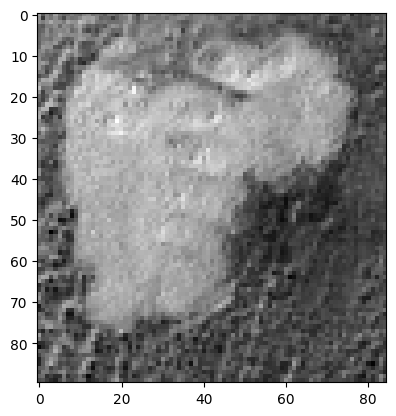

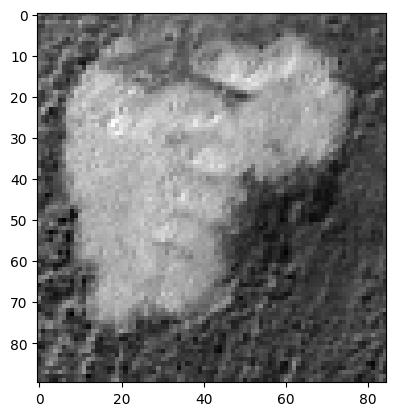

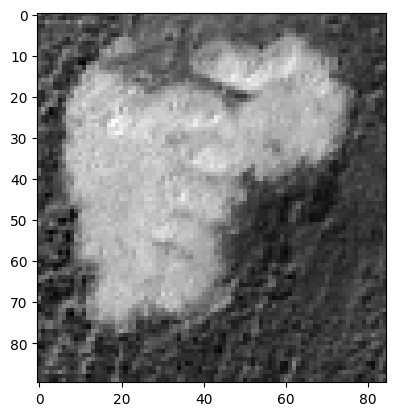

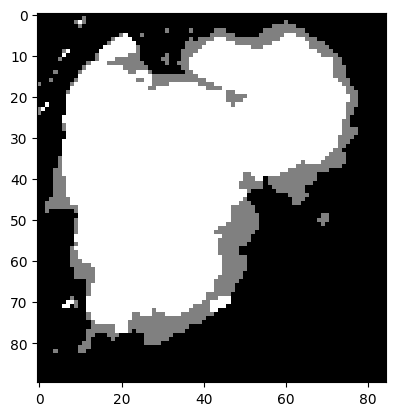

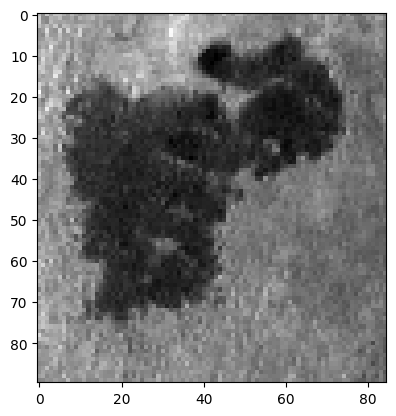

In [ ]:
Show_Image_Layers(my_diff_image)

In [ ]:
rows, columns = my_diff_image['differences'].shape

stable = 0
stable_NDVI = []

change = 0
change_NDVI = []

bare = 0
bare_NDVI = []

for row in range(rows):
  for colum in range(columns):

    if my_diff_image['differences'][row, colum] == 0:
      stable = stable + 1
      stable_NDVI.append(my_diff_image['NDVI'][row, colum])

    elif my_diff_image['differences'][row, colum] == 1:
      change = change + 1
      change_NDVI.append(my_diff_image['NDVI'][row, colum])

    elif my_diff_image['differences'][row, colum] == 2:
      bare = bare + 1
      bare_NDVI.append(my_diff_image['NDVI'][row, colum])

In [ ]:
print('stable sand NDVI = ' + str(stat.mean(stable_NDVI)))
print('change sand NDVI = ' + str(stat.mean(change_NDVI)))
print('bare sand NDVI = ' + str(stat.mean(bare_NDVI)))

stable sand NDVI = 0.07078546972012059
change sand NDVI = 0.07096127691323202
bare sand NDVI = 0.06244712107087753


In [ ]:
print('stable sand pixels = ' + str(stable))
print('change sand pixels = ' + str(change))
print('bare sand pixels = ' + str(bare))

stable sand pixels = 3787
change sand pixels = 769
bare sand pixels = 3094


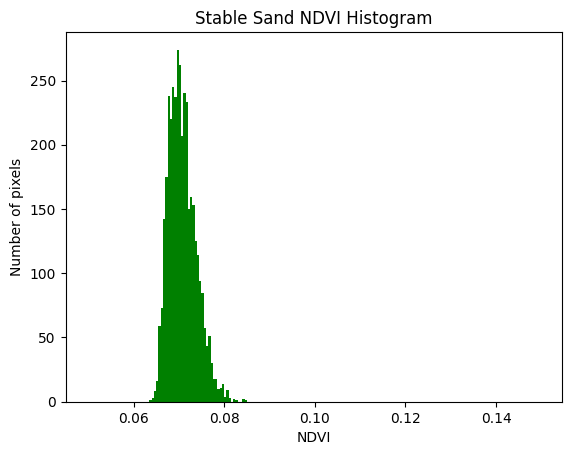

In [ ]:
plt.figure()
plt.hist(stable_NDVI, bins=np.arange(0.05, 0.15, 0.0005), color = 'green')
plt.title('Stable Sand NDVI Histogram')
plt.xlabel('NDVI')
plt.ylabel('Number of pixels')
plt.show()

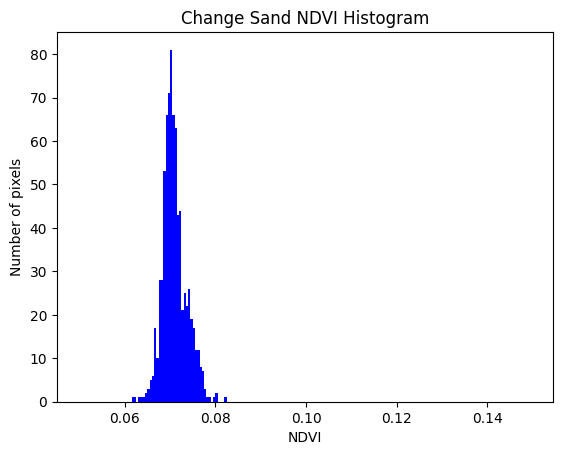

In [ ]:
plt.figure()
plt.hist(change_NDVI, bins=np.arange(0.05, 0.15, 0.0005), color = 'blue')
plt.title('Change Sand NDVI Histogram')
plt.xlabel('NDVI')
plt.ylabel('Number of pixels')
plt.show()

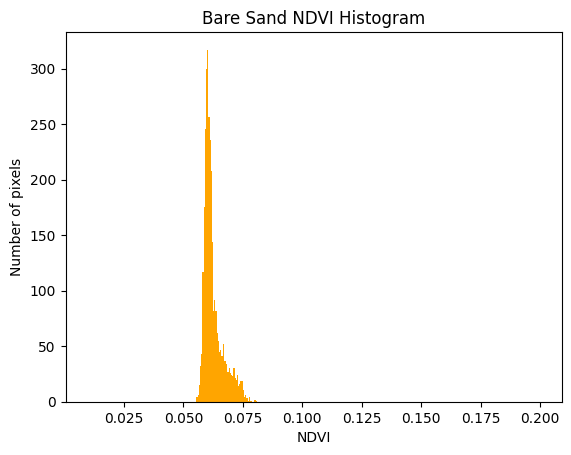

In [ ]:
plt.figure()
plt.hist(bare_NDVI, bins=np.arange(0.01, 0.2, 0.0005), color = 'orange')
plt.title('Bare Sand NDVI Histogram')
plt.xlabel('NDVI')
plt.ylabel('Number of pixels')
plt.show()

In [ ]:
ima = my_diff_image['NDVI']
rows, columns = ima.shape

for row in range(rows):
  for colum in range(columns):
    if ima[row, colum] < 0.1:
      ima[row, colum] = 0
    else:
      ima[row, colum] = 1



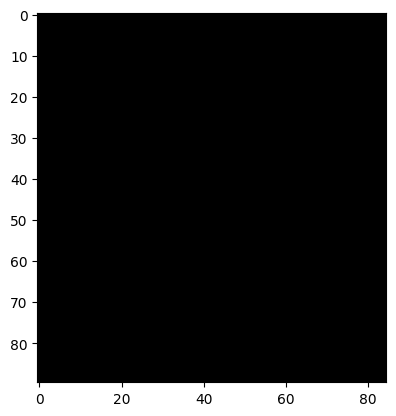

In [ ]:
plt.imshow(ima, 'gray')

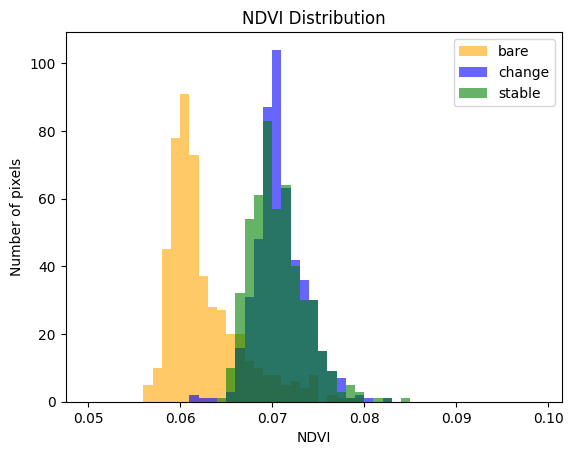

In [ ]:
b = []
c = []
s = []


for i in range(500):
  b.append( bare_NDVI[ random.randint(0 ,bare - 1) ] )
  c.append( change_NDVI[ random.randint(0, change - 1) ] )
  s.append( stable_NDVI[ random.randint(0 ,stable - 1) ] )


alpha = 0.6
bins = np.arange(0.05, 0.1, 0.001)
plt.figure()
plt.hist(b, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'orange')
plt.hist(c, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'blue')
plt.hist(s, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'green')
plt.title('NDVI Distribution')
plt.legend(('bare', 'change', 'stable'))
plt.xlabel('NDVI')
plt.ylabel('Number of pixels')
plt.show()

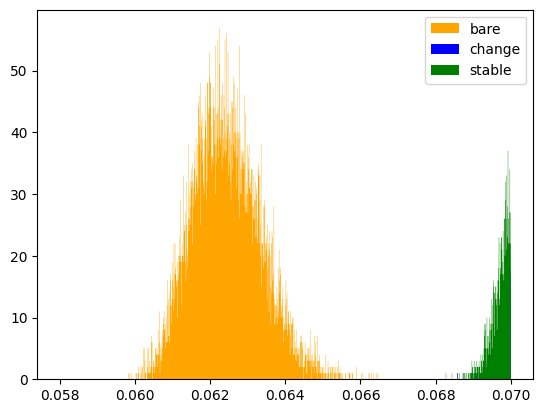

In [ ]:
bm = []
cm = []
sm = []

for j in range(10000):
  b = []
  c = []
  s = []

  for i in range(20):
    b.append( bare_NDVI[ random.randint(0 ,bare - 1) ] )
    c.append( change_NDVI[ random.randint(0, change - 1) ] )
    s.append( stable_NDVI[ random.randint(0 ,stable - 1) ] )

  bm.append(stat.mean(b))
  cm.append(stat.mean(c))
  sm.append(stat.mean(s))

alpha = 1
bins = np.arange(0.058, 0.070, 0.00001)

plt.figure()
plt.hist(bm, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'orange')
plt.hist(cm, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'blue')
plt.hist(sm, bins = bins, histtype = 'stepfilled', alpha = alpha, color = 'green')
plt.legend(('bare', 'change', 'stable'))
plt.show()

## Gif of the results

In [ ]:
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat=False)
ani.save("Conway.gif", writer="imagemagick")

plt.show()

NameError: ignored

## Saving results

In [ ]:
dlta = []
ye = []
for i in range(len(years_list) - 1):
  dlta.append( ( bare_sand_percentage[i] - bare_sand_percentage[i+1] ) / ( years_list[i] - years_list[i+1] ) )
  ye.append( ( years_list[i] + years_list[i+1] ) / 2)


In [ ]:
# saving as csv

file_name = 'aaaaaaaaaaaa' + '.csv'

data = {'year': ye,
        'dlta percentage': dlta,}

data_df =  pd.DataFrame(data)

data_df.to_csv(file_name)
files.download(file_name)

In [ ]:
# NOTE!!! Download until 2013

for idx, image in enumerate(classified_images):
  print(str(years_list[idx]))
  image_name = 'classfy_' + str(years_list[idx]) + '.tif'
  imsave(image_name, np.uint8(image))
  files.download(image_name)

In [ ]:
# image save as JPEG

from PIL import Image

for idx, image in enumerate(classified_images):
    image_name = 'classfy_' + str(years_list[idx]) + '.JPEG'
    imsave(image_name, np.uint8(image))
    files.download(image_name)

## Things to keep

In [ ]:
# Removes all zeros from the last row

for band in im:
  im[band][-1, :] = ( im[band][-2, :] + im[band][-3, :] ) / 2

#df_22 = pd.DataFrame(im['blue'])
#df_22

### Texture

In [ ]:
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size))

In [ ]:
max_filter = []
mean_filter = []

for my_image in im:
  max_filter.append(maximum(im[my_image], kernel))
  mean_filter.append(mean(im[my_image], kernel))

### Clustering

#### Preparation for clustering

In [ ]:
bands_amount = 6
filters_amount = 2

layers_amount = bands_amount *  filters_amount + bands_amount
rows_amount, colums_amount = im['blue'].shape  # it should be changed in case the names of the bands are changed during the image import

In [ ]:
# stacking the layers
stack_img = np.zeros((rows_amount, colums_amount, layers_amount))

for i, band in enumerate(im):
  # all filters shold be in this loop
  stack_img[:, :, i] = im[band]
  stack_img[:, :, i + bands_amount] = mean_filter[i]
  stack_img[:, :, i + bands_amount * 2] = max_filter[i]

In [ ]:
# flating tha layers
flat_img = stack_img.reshape((-1, layers_amount))

#### 2 clusters classification

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k).fit(flat_img)
clusters = kmeans.predict(flat_img)

# reshape back
clusters_img = clusters.reshape(im['red'].shape)

### Show result

In [ ]:
plt.imshow(clusters_img, 'gray')

In [ ]:
plt.imshow(im['blue'], 'gray')

### Analysis

In [ ]:
_1986_06_06 = clusters_img[10 : 110, 25 : 115]
plt.imshow(_1986_06_06, 'gray')

In [ ]:
plt.imshow(_1986_06_06, 'gray')

In [ ]:
_2022_06_25  = clusters_img[10 : 110, 25 : 115]
plt.imshow(_2022_06_25, 'gray')

In [ ]:
plt.imshow(_2022_06_25, 'gray')

In [ ]:
# Converts between zeros and ones
_2022_06_25 = _2022_06_25 * (-1) + 1

In [ ]:
# Converts between zeros and ones
_1986_06_06 = _1986_06_06 * (-1) + 1

In [ ]:
difference = _2022_06_25 - _1986_06_06

In [ ]:
plt.imshow(difference, 'gray')

In [ ]:
# stable pixels

stable_86 = How_Many_Pixels_Are_Specific_Value(_1986_06_06)
stable_22 = How_Many_Pixels_Are_Specific_Value( _2022_06_25)

print(stable_86)
print(stable_22)

In [ ]:
# stable percentage

stabilized_percentage =  100 - ( (stable_22 / stable_86) * 100 )
print(stabilized_percentage)

In [ ]:
# stable area

stabilized_area = (stable_86 - stable_22) * 30 * 30
print(stabilized_area)

In [ ]:
imsave('2022_06_25.jpg', _2022_06_25)
files.download("2022_06_25.jpg")

imsave('difference.jpg', difference)
files.download("difference.jpg")

imsave('1986_06_06.jpg', _1986_06_06)
files.download("1986_06_06.jpg")

### Elbow method

In [ ]:
k = 10
wcss = []
for i in range(1, k):
  kmeans = KMeans(n_clusters=i).fit(flat_img)
  wcss.append(kmeans.inertia_)

In [ ]:
from numpy import arange

plt.plot(range(1, k), wcss, 'purple')
plt.scatter(range(1, k), wcss, marker='o', c='purple', s=25)
plt.xticks(arange(k, step=1))
plt.xlim(0.75, 10.25)

plt.title('Elbow Method')
plt.ylabel('WCSS')
plt.xlabel('Number of Centers')

### Examining the variables

In [ ]:
from PIL import Image
import numpy as np

def create_rgb_image(bands):
    # Extract red, green, and blue bands from the dictionary
    red_band = bands.get('red', None)
    green_band = bands.get('green', None)
    blue_band = bands.get('blue', None)

    if red_band is None or green_band is None or blue_band is None:
        raise ValueError("Red, green, and blue bands are required in the dictionary.")

    # Create a numpy array from the bands
    image_array = np.stack([red_band, green_band, blue_band], axis=-1)
    print(image_array.shape)

    # Convert the array to PIL Image
    image = Image.fromarray(np.uint8(image_array))

    # Display the image
    image.show()


In [ ]:
image = not_classified[0]['blue']
plt.imshow(image, 'gray')

In [ ]:
file_name = 'aaaaaaaaaaaa' + '.csv'

data_df =  pd.DataFrame(not_classified[0]['blue'])

data_df.to_csv(file_name)
files.download(file_name)

In [ ]:
image = not_classified[0]

In [ ]:
def image_show(image):
  for i in image:
    plt.imshow(image[i], 'gray')
    plt.show()

In [ ]:
image_show(image)